In [ ]:
import os
os.chdir(r'D:\AFT\Feature_Engineer_Kaggle_2025')

In [2]:
import numpy as np
import pandas as pd
import os
base_path = r'E:\\learn_pytorch\AFT'  # 原始字符串
# 检查路径是否存在
if os.path.exists(base_path):
    for dirname, _, filenames in os.walk(base_path):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print(f"路径不存在: {base_path}")

E:\\learn_pytorch\AFT\cross_section_features.parquet
E:\\learn_pytorch\AFT\features_importance.py
E:\\learn_pytorch\AFT\feature_importance_results.csv
E:\\learn_pytorch\AFT\multilinear_and_tree-feature(1).ipynb
E:\\learn_pytorch\AFT\multilinear_and_tree-feature.ipynb


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn as sk
import lightgbm
SEED = 42

# 1.(co-)multi-linear feature_impoartances

**multilinear影响**  
输出的特征重要性排序在不同sample，特征顺序，种子上不稳定  
两个相似的样本会互相降低feature_importance  
删去一个特征使得其他特征的重要性排序发生明显改变  


## 1.2读取横截面因子

In [4]:
# cross_section_features = pd.read_parquet(os.path.join(dirname, "cross_section_features.parquet")).iloc[:1000000]
cross_section_features = pd.read_parquet(
    "cross_section_features.parquet",
    engine="pyarrow").iloc[:100000]

In [5]:
cross_section_features.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O'), dtype('float32')],
      dtype=object)

In [6]:
cross_section_features.dtypes[cross_section_features.dtypes=='O']

row_id    object
dtype: object

使用前把“row_id”和“target”drop掉

In [7]:
X_train = cross_section_features.query("target.notna()").drop(['row_id'], axis=1)
y_train = X_train.pop("target")

In [8]:
X_train.columns[X_train.isnull().sum()!=0]

Index(['wap_y', 'mid_price_y'], dtype='object')

In [9]:
X_train.query("seconds_in_bucket>300")[['wap_y', 'mid_price_y']].isnull().sum()

wap_y          0
mid_price_y    0
dtype: int64

In [10]:
X_train.drop(['wap_y', 'mid_price_y'],axis=1,inplace=True)

看一下有inf的值

In [11]:
cols_contain_inf = (
    X_train
    .select_dtypes("float")
    .columns
    [
        np.isinf(
            X_train
            .select_dtypes("float")
        ).sum()!=0
    ]
)

In [12]:
cols_contain_inf = (
    X_train
    .select_dtypes("float")
    .columns
    [
        np.isinf(
            X_train
            .select_dtypes("float")
        ).sum()!=0
    ]
)

X_train[cols_contain_inf] = (
    X_train
    [cols_contain_inf]
    .mask(
        np.isinf(X_train[cols_contain_inf])
    )
)

inf换成nan

In [13]:
X_train[cols_contain_inf] = (
    X_train
    [cols_contain_inf]
    .mask(
        np.isinf(X_train[cols_contain_inf])
    )
)

In [14]:
(X_train
    .select_dtypes("float")
    .columns
    [
        np.isinf(
            X_train
            .select_dtypes("float")
        ).sum()!=0
    ])

Index([], dtype='object')

# 3.correlation和feature_importances

## 3.1 相关性

In [15]:
corr_matrix = X_train.corr()

20个看一下热力图, 有一些高度相关的

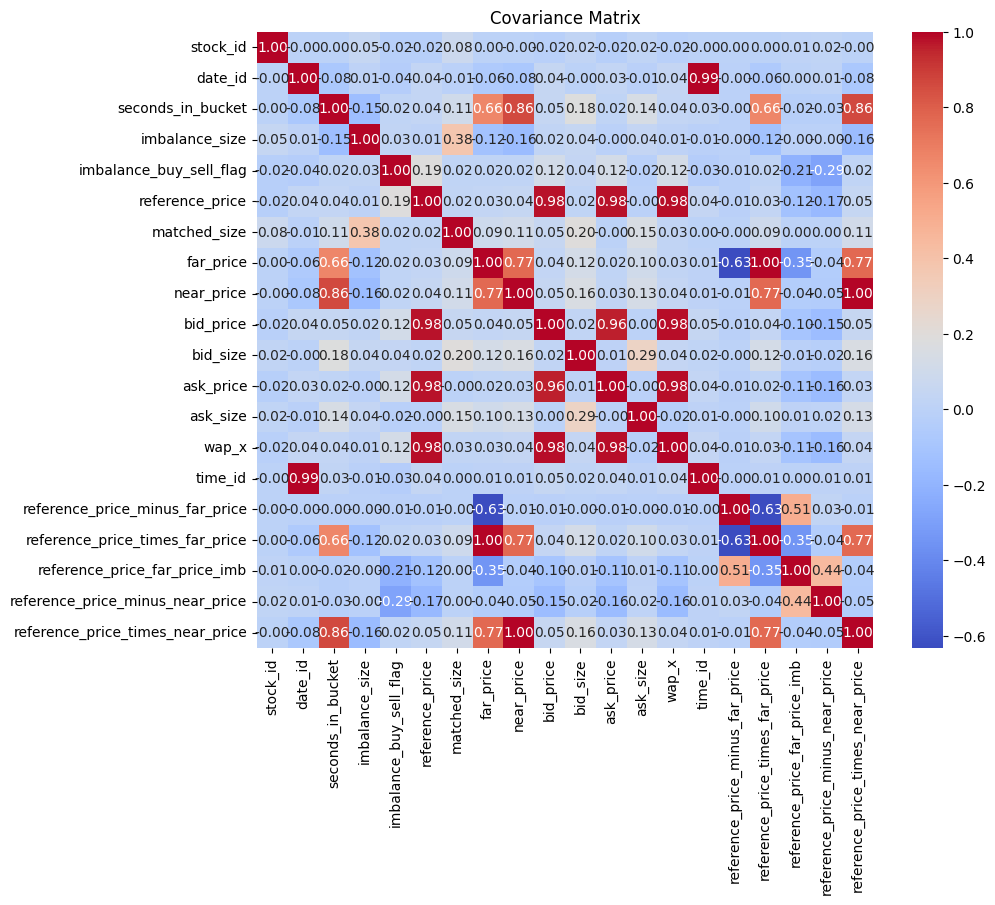

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.iloc[:20,:20], annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Covariance Matrix')
plt.show()

按顺序排的平均相关性的绝对值

<Axes: >

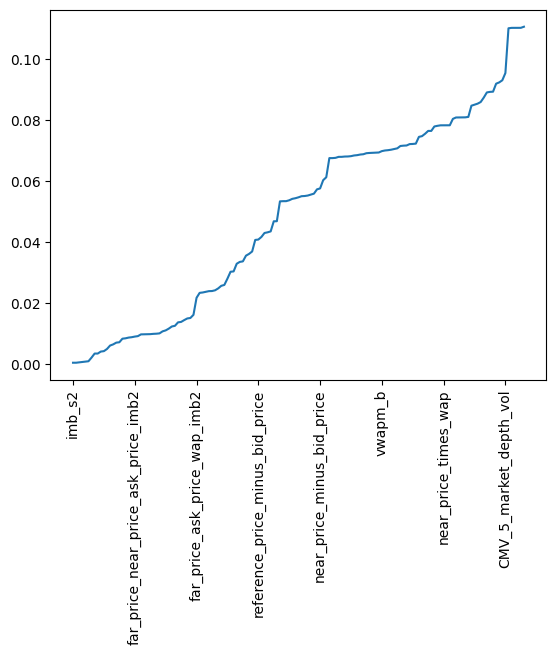

In [17]:
corr_matrix.mean().abs().sort_values().plot(rot=90)

In [18]:
feature_corr_series = corr_matrix.mean()

## 3.2 5折训练的lightgbm的平均重要性，permutation重排2次
split，gain

In [ ]:
estimator = lightgbm.LGBMRegressor(
    boosting_type='gbdt', 
    num_leaves=31, 
    max_depth=-1, 
    learning_rate=0.1, 
    n_estimators=100, 
    subsample_for_bin=200000, 
    objective='mae', 
    class_weight=None, 
    min_split_gain=0.0, 
    min_child_weight=0.001, 
    min_child_samples=20, 
    subsample=1.0, 
    subsample_freq=0, 
    colsample_bytree=1.0, 
    reg_alpha=0.0, 
    reg_lambda=0.0, 
    random_state=SEED, 
    n_jobs=-1, 
    importance_type='gain',#split
    force_row_wise=True
)

In [ ]:
n_splits = 5
n_repeats = 1

In [ ]:
val_predictions = np.zeros(len(X_train))
val_scores = []
model_list = []
feature_importance_list = []
feature_importance_permuation_list = []#pd.DataFrame()
splitter = sk.model_selection.TimeSeriesSplit(n_splits).split(X_train, y_train)
for fold, (train_idx, val_idx) in enumerate(splitter):
    model = sk.base.clone(estimator)

    # Define train and val set
    X_train_fold = X_train.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = X_train.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx]

    model.fit(X_train_fold, y_train_fold)

    #permuation
    result = permutation_importance(model, X_val_fold, y_val_fold, n_repeats=n_repeats, random_state=SEED)
    feature_importance = result.importances_mean
    feature_names = X_train.columns
    feature_importance_permuation_list.append(pd.Series(index=feature_names, data=feature_importance))

    #cover or gain
    feature_importance_list.append(pd.Series(index=feature_names, data=model.feature_importances_))
    val_scores.append(sk.metrics.mean_absolute_error(model.predict(X_val_fold), y_val_fold))
    model_list.append(model)
print(f'Val Score: {np.mean(val_scores):.2f} ± {np.std(val_scores):.5f}')

存gain和permuation的importance

In [ ]:
gain_feature_importance_series = pd.concat(feature_importance_list,axis=1).mean(axis=1)

In [ ]:
permutation_feature_importance_series = pd.concat(feature_importance_permuation_list,axis=1).mean(axis=1)

In [ ]:
feature_importance_and_corr = pd.concat(
    [
        permutation_feature_importance_series.to_frame().rename(columns={0:"permuation_feature_importance"}),
        gain_feature_importance_series.to_frame().rename(columns={0:"gain_feature_importance"}),
        feature_corr_series.to_frame().rename(columns={0:"feature_corr_mean"})
    ],
    axis=1
)

## 3.3比较一下重要性和相关性

describe看一下数据分布

In [ ]:
feature_importance_and_corr.describe()

画个图（
数据分布方差大，又不好删
1.clip 3被sigma
2.loglog
3.rank
）

In [ ]:
feature_importance_and_corr["permuation_feature_importance"] = feature_importance_and_corr["permuation_feature_importance"].sort_values().clip(-1000,0.001)#.plot(marker="o")

In [ ]:
def log_xplus(df,plus=1):
    return np.log(df-df.min()+plus)
def loglog(df,times=2,plus=1):
    if times==0:
        return df
    return loglog(log_xplus(df,plus),times-1)

In [ ]:
loglog_feature_importance_and_corr = loglog(feature_importance_and_corr,1,1)

In [ ]:
scaler = StandardScaler()
scaler.fit(loglog_feature_importance_and_corr)
pd.DataFrame(
    scaler.fit_transform(loglog_feature_importance_and_corr),
    columns=loglog_feature_importance_and_corr.columns,
    index=loglog_feature_importance_and_corr.index
).boxplot(rot=90)

**和其他特征相关性高的更容易在gain的排序下变得不重要，permutation能避免（相关性0.06）**

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(feature_importance_and_corr.rank().corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Covariance Matrix')
plt.show()

# 3.相似的特征和feature_importances

特征加噪声

In [ ]:
X_train_std = X_train.std()
X_train_noise = np.array([np.random.normal(0,X_train_std) for _ in tqdm(range(len(X_train)))])

In [ ]:
X_train.corrwith(X_train+X_train_noise).min().min()

In [ ]:
X_train_double = X_train.merge(X_train+X_train_noise,left_index=True,right_index=True)

run一下重要性

In [ ]:
val_predictions = np.zeros(len(X_train_double))
val_scores = []
model_list = []
feature_importance_list = []
feature_importance_permuation_list = []#pd.DataFrame()
splitter = sk.model_selection.TimeSeriesSplit(n_splits).split(X_train_double, y_train)
for fold, (train_idx, val_idx) in enumerate(splitter):
    model = sk.base.clone(estimator)

    # Define train and val set
    X_train_fold = X_train_double.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = X_train_double.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx]

    model.fit(X_train_fold, y_train_fold)

    #permuation
    result = permutation_importance(model, X_val_fold, y_val_fold, n_repeats=n_repeats, random_state=SEED)
    feature_importance = result.importances_mean
    feature_names = X_train_double.columns
    feature_importance_permuation_list.append(pd.Series(index=feature_names, data=feature_importance))

    #cover or gain
    feature_importance_list.append(pd.Series(index=feature_names, data=model.feature_importances_))
    val_scores.append(sk.metrics.mean_absolute_error(model.predict(X_val_fold), y_val_fold))
    model_list.append(model)
print(f'Val Score: {np.mean(val_scores):.2f} ± {np.std(val_scores):.5f}')

In [ ]:
permutation_feature_importance_series_double = pd.concat(feature_importance_permuation_list,axis=1).mean(axis=1)
gain_feature_importance_series_double = pd.concat(feature_importance_list,axis=1).mean(axis=1)

In [ ]:
feature_importance_list

In [ ]:
X_train_double = X_train.copy()

In [ ]:
val_predictions = np.zeros(len(X_train_double))
val_scores = []
model_list = []
feature_importance_list = []
feature_importance_permuation_list = []#pd.DataFrame()
splitter = sk.model_selection.TimeSeriesSplit(n_splits).split(X_train_double, y_train)
for fold, (train_idx, val_idx) in enumerate(splitter):
    model = sk.base.clone(estimator)

    # Define train and val set
    X_train_fold = X_train_double.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = X_train_double.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx]

    model.fit(X_train_fold, y_train_fold)

    #permuation
    result = permutation_importance(model, X_val_fold, y_val_fold, n_repeats=n_repeats, random_state=SEED)
    feature_importance = result.importances_mean
    feature_names = X_train_double.columns
    feature_importance_permuation_list.append(pd.Series(index=feature_names, data=feature_importance))

    #cover or gain
    feature_importance_list.append(pd.Series(index=feature_names, data=model.feature_importances_))
    val_scores.append(sk.metrics.mean_absolute_error(model.predict(X_val_fold), y_val_fold))
    model_list.append(model)
print(f'Val Score: {np.mean(val_scores):.2f} ± {np.std(val_scores):.5f}')

In [ ]:
permutation_feature_importance_series = pd.concat(feature_importance_permuation_list,axis=1).mean(axis=1)
gain_feature_importance_series = pd.concat(feature_importance_list,axis=1).mean(axis=1)

In [ ]:
permutation_feature_importance_df = permutation_feature_importance_series.to_frame().rename(columns={0:"permutation_feature_importance"})
permutation_feature_importance_df["permutation_feature_importance_origin"] = permutation_feature_importance_series_double.iloc[:151].values
permutation_feature_importance_df["permutation_feature_importance_withnoise"] = permutation_feature_importance_series_double.iloc[151:].values

In [ ]:
gain_feature_importance_df = gain_feature_importance_series.to_frame().rename(columns={0:"gain_feature_importance"})
gain_feature_importance_df["gain_feature_importance_origin"] = gain_feature_importance_series_double.iloc[:151].values
gain_feature_importance_df["gain_feature_importance_withnoise"] = gain_feature_importance_series_double.iloc[151:].values

画个图

In [ ]:
fig,axes = plt.subplots(2,2,figsize=(14,8))
permutation_feature_importance_df.sort_values("permutation_feature_importance").iloc[0:10].plot(kind="bar",rot=45,ax=axes.flatten()[0])
permutation_feature_importance_df.sort_values("permutation_feature_importance").iloc[-10:].plot(kind="bar",rot=45,ax=axes.flatten()[1])
gain_feature_importance_df.sort_values("gain_feature_importance").iloc[0:10].plot(kind="bar",rot=45,ax=axes.flatten()[2])
gain_feature_importance_df.sort_values("gain_feature_importance").iloc[-10:].plot(kind="bar",rot=45,ax=axes.flatten()[3])
plt.tight_layout()

In [ ]:
permutation_feature_importance_df.abs().sort_values("permutation_feature_importance").iloc[:20].plot.barh()#(kind="bar",figsize=(14,4))

**重要性高的特征受噪声影响小**  
**重要性为0的特征如果有一些和他相关性高（>0.7）的特征可能会被分配一些重要性**  
**重要性低的特征受共线性影响变化大**

# 4.去部分特征后feature_importances排序变化

In [ ]:
X_train_double = X_train.drop("mid_price_corr",axis=1)

In [ ]:
val_predictions = np.zeros(len(X_train_double))
val_scores = []
model_list = []
feature_importance_list = []
feature_importance_permuation_list = []#pd.DataFrame()
splitter = sk.model_selection.TimeSeriesSplit(n_splits).split(X_train_double, y_train)
for fold, (train_idx, val_idx) in enumerate(splitter):
    model = sk.base.clone(estimator)

    # Define train and val set
    X_train_fold = X_train_double.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = X_train_double.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx]

    model.fit(X_train_fold, y_train_fold)

    #permuation
    result = permutation_importance(model, X_val_fold, y_val_fold, n_repeats=n_repeats, random_state=SEED)
    feature_importance = result.importances_mean
    feature_names = X_train_double.columns
    feature_importance_permuation_list.append(pd.Series(index=feature_names, data=feature_importance))

    #cover or gain
    feature_importance_list.append(pd.Series(index=feature_names, data=model.feature_importances_))
    val_scores.append(sk.metrics.mean_absolute_error(model.predict(X_val_fold), y_val_fold))
    model_list.append(model)
print(f'Val Score: {np.mean(val_scores):.2f} ± {np.std(val_scores):.5f}')

In [ ]:
permutation_feature_importance_series_del1 = pd.concat(feature_importance_permuation_list,axis=1).mean(axis=1)
gain_feature_importance_series_del1 = pd.concat(feature_importance_list,axis=1).mean(axis=1)

In [ ]:
gain_feature_importance_series_del1.nlargest(10)

In [ ]:
permutation_feature_importance_series_del1.nlargest(10)

## 新增
1.先把所有特征重要性方法聚合起来，将所有结果输出出来
2.检查不同方法得到的特征重要性之间的差异
3.将上述方法加权平均，得到一个综合的特征重要性，并取出top300作为最终的特征
4.检查top300特征的相关性，删除高相关因子

In [19]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import sklearn.metrics as sk_metrics
import sklearn.model_selection as sk_model_selection
import sklearn.inspection as sk_inspection
import shap
from sklearn.base import clone
import warnings
warnings.filterwarnings('ignore')

class FeatureImportanceAnalyzer:
    """
    特征重要性分析器
    使用多种方法计算特征重要性并综合评估
    """
    
    def __init__(self, seed=42, n_splits=5, n_repeats=5):
        """
        Parameters:
        -----------
        seed : int
            随机种子
        n_splits : int
            交叉验证折数
        n_repeats : int
            Permutation Importance重复次数
        """
        self.SEED = seed
        self.n_splits = n_splits
        self.n_repeats = n_repeats
        self.results = {}
        
    def _get_lightgbm_estimator(self):
        """LGBM和XGBOOST参数我随便设的，需要改"""
        return lgb.LGBMRegressor(
            boosting_type='gbdt',
            num_leaves=31,
            max_depth=-1,
            learning_rate=0.1,
            n_estimators=100,
            subsample_for_bin=200000,
            objective='mae',
            class_weight=None,
            min_split_gain=0.0,
            min_child_weight=0.001,
            min_child_samples=20,
            subsample=1.0,
            subsample_freq=0,
            colsample_bytree=1.0,
            reg_alpha=0.0,
            reg_lambda=0.0,
            random_state=self.SEED,
            n_jobs=-1,
            importance_type='gain',
            force_row_wise=True
        )
    
    def _get_xgboost_estimator(self):
        return xgb.XGBRegressor(
            objective='reg:absoluteerror',
            learning_rate=0.1,
            n_estimators=100,
            max_depth=6,
            subsample=1.0,
            colsample_bytree=1.0,
            reg_alpha=0.0,
            reg_lambda=0.0,
            random_state=self.SEED,
            n_jobs=-1
        )
    
    def calculate_lightgbm_importance(self, X_train, y_train):
        """
        计算LightGBM特征重要性
        
        Parameters:
        -----------
        X_train : pd.DataFrame
            训练特征
        y_train : pd.Series
            训练目标
            
        Returns:
        --------
        dict : 包含重要性结果和验证分数的字典
        """
        print("计算LightGBM特征重要性...")
        estimator = self._get_lightgbm_estimator()
        
        val_scores = []
        gain_importance_list = []
        split_importance_list = []
        
        # 使用时间序列交叉验证
        splitter = sk_model_selection.TimeSeriesSplit(n_splits=self.n_splits).split(X_train, y_train)
        
        for fold, (train_idx, val_idx) in enumerate(splitter):
            model = clone(estimator)
            
            # 划分训练集和验证集
            X_train_fold = X_train.iloc[train_idx]
            y_train_fold = y_train.iloc[train_idx]
            X_val_fold = X_train.iloc[val_idx]
            y_val_fold = y_train.iloc[val_idx]
            
            # 训练模型
            model.fit(X_train_fold, y_train_fold)
            
            # 获取两种重要性
            gain_importance_list.append(
                pd.Series(index=X_train.columns, data=model.feature_importances_)
            )
            
            # 计算split重要性
            model.set_params(importance_type='split')
            model.fit(X_train_fold, y_train_fold)
            split_importance_list.append(
                pd.Series(index=X_train.columns, data=model.feature_importances_)
            )
            
            # 验证分数
            val_score = sk_metrics.mean_absolute_error(
                model.predict(X_val_fold), y_val_fold
            )
            val_scores.append(val_score)
        
        # 计算平均重要性
        gain_importance = pd.concat(gain_importance_list, axis=1).mean(axis=1)
        split_importance = pd.concat(split_importance_list, axis=1).mean(axis=1)
        
        result = {
            'gain_importance': gain_importance,
            'split_importance': split_importance,
            'val_scores': val_scores,
            'mean_val_score': np.mean(val_scores)
        }
        
        print(f"LightGBM验证分数: {np.mean(val_scores):.4f} ± {np.std(val_scores):.4f}")
        return result
    
    def calculate_xgboost_importance(self, X_train, y_train):
        """
        计算XGBoost特征重要性
        
        Parameters:
        -----------
        X_train : pd.DataFrame
            训练特征
        y_train : pd.Series
            训练目标
            
        Returns:
        --------
        dict : 包含重要性结果和验证分数的字典
        """
        print("计算XGBoost特征重要性...")
        estimator = self._get_xgboost_estimator()
        
        val_scores = []
        weight_importance_list = []
        gain_importance_list = []
        cover_importance_list = []
        
        splitter = sk_model_selection.TimeSeriesSplit(n_splits=self.n_splits).split(X_train, y_train)
        
        for fold, (train_idx, val_idx) in enumerate(splitter):
            model = clone(estimator)
            
            X_train_fold = X_train.iloc[train_idx]
            y_train_fold = y_train.iloc[train_idx]
            X_val_fold = X_train.iloc[val_idx]
            y_val_fold = y_train.iloc[val_idx]
            
            model.fit(X_train_fold, y_train_fold)
            
            # 获取不同类型的特征重要性
            importance_dict = model.get_booster().get_score(importance_type='weight')
            weight_importance_list.append(
                pd.Series(importance_dict).reindex(X_train.columns, fill_value=0)
            )
            
            importance_dict = model.get_booster().get_score(importance_type='gain')
            gain_importance_list.append(
                pd.Series(importance_dict).reindex(X_train.columns, fill_value=0)
            )
            
            importance_dict = model.get_booster().get_score(importance_type='cover')
            cover_importance_list.append(
                pd.Series(importance_dict).reindex(X_train.columns, fill_value=0)
            )
            
            val_score = sk_metrics.mean_absolute_error(
                model.predict(X_val_fold), y_val_fold
            )
            val_scores.append(val_score)
        
        # 计算平均重要性
        weight_importance = pd.concat(weight_importance_list, axis=1).mean(axis=1)
        gain_importance = pd.concat(gain_importance_list, axis=1).mean(axis=1)
        cover_importance = pd.concat(cover_importance_list, axis=1).mean(axis=1)
        
        result = {
            'weight_importance': weight_importance,
            'gain_importance': gain_importance,
            'cover_importance': cover_importance,
            'val_scores': val_scores,
            'mean_val_score': np.mean(val_scores)
        }
        
        print(f"XGBoost验证分数: {np.mean(val_scores):.4f} ± {np.std(val_scores):.4f}")
        return result
    
    def calculate_permutation_importance(self, X_train, y_train, model_type='lightgbm'):
        """
        计算Permutation特征重要性
        
        Parameters:
        -----------
        X_train : pd.DataFrame
            训练特征
        y_train : pd.Series
            训练目标
        model_type : str
            模型类型 ('lightgbm' 或 'xgboost')，permutation重要性与model无关，选择其一即可
            
        Returns:
        --------
        pd.Series : Permutation重要性
        """
        print(f"计算{model_type}的Permutation重要性...")
        
        if model_type == 'lightgbm':
            estimator = self._get_lightgbm_estimator()
        else:
            estimator = self._get_xgboost_estimator()
        
        permutation_importance_list = []
        val_scores = []
        
        splitter = sk_model_selection.TimeSeriesSplit(n_splits=self.n_splits).split(X_train, y_train)
        
        for fold, (train_idx, val_idx) in enumerate(splitter):
            model = clone(estimator)
            
            X_train_fold = X_train.iloc[train_idx]
            y_train_fold = y_train.iloc[train_idx]
            X_val_fold = X_train.iloc[val_idx]
            y_val_fold = y_train.iloc[val_idx]
            
            model.fit(X_train_fold, y_train_fold)
            
            # 计算Permutation Importance
            result = sk_inspection.permutation_importance(
                model, X_val_fold, y_val_fold, 
                n_repeats=self.n_repeats, 
                random_state=self.SEED,
                scoring='neg_mean_absolute_error'
            )
            
            permutation_importance_list.append(
                pd.Series(index=X_train.columns, data=result.importances_mean)
            )
            
            val_score = sk_metrics.mean_absolute_error(
                model.predict(X_val_fold), y_val_fold
            )
            val_scores.append(val_score)
        
        # 计算平均Permutation重要性
        permutation_importance = pd.concat(permutation_importance_list, axis=1).mean(axis=1)
        
        print(f"{model_type} Permutation验证分数: {np.mean(val_scores):.4f} ± {np.std(val_scores):.4f}")
        return permutation_importance
    
    def calculate_shap_importance(self, X_train, y_train, model_type='lightgbm', sample_size=1000):
        """
        计算SHAP特征重要性
        
        Parameters:
        -----------
        X_train : pd.DataFrame
            训练特征
        y_train : pd.Series
            训练目标
        model_type : str
            模型类型 ('lightgbm' 或 'xgboost')
        sample_size : int
            用于SHAP计算的样本数量
            
        Returns:
        --------
        pd.Series : SHAP重要性
        """
        print(f"计算{model_type}的SHAP重要性...")
        
        if model_type == 'lightgbm':
            estimator = self._get_lightgbm_estimator()
        else:
            estimator = self._get_xgboost_estimator()
        
        # 使用全部数据训练一个模型用于SHAP分析
        if len(X_train) > sample_size:
            # 对大数据集进行采样
            sample_idx = np.random.choice(len(X_train), sample_size, replace=False)
            X_sample = X_train.iloc[sample_idx]
            y_sample = y_train.iloc[sample_idx]
        else:
            X_sample = X_train
            y_sample = y_train
        
        model = clone(estimator)
        model.fit(X_sample, y_sample)
        
        # 计算SHAP值
        if model_type == 'lightgbm':
            explainer = shap.TreeExplainer(model)
        else:
            explainer = shap.TreeExplainer(model)
        
        shap_values = explainer.shap_values(X_sample)
        
        # 计算平均绝对SHAP值作为特征重要性
        if isinstance(shap_values, list):
            shap_values = shap_values[0]
        
        shap_importance = pd.Series(
            index=X_train.columns,
            data=np.abs(shap_values).mean(axis=0)
        )
        
        return shap_importance
    
    def compute_all_importance(self, X_train, y_train):
        """
        计算所有特征重要性方法
        
        Parameters:
        -----------
        X_train : pd.DataFrame
            训练特征
        y_train : pd.Series
            训练目标
            
        Returns:
        --------
        dict : 包含所有重要性结果的字典
        """
        print("开始计算所有特征重要性方法...")
        
        # LightGBM重要性
        lgb_results = self.calculate_lightgbm_importance(X_train, y_train)
        self.results['lightgbm'] = lgb_results
        
        # XGBoost重要性
        xgb_results = self.calculate_xgboost_importance(X_train, y_train)
        self.results['xgboost'] = xgb_results
        
        # Permutation重要性
        self.results['permutation_lgb'] = self.calculate_permutation_importance(
            X_train, y_train, 'lightgbm'
        )
        self.results['permutation_xgb'] = self.calculate_permutation_importance(
            X_train, y_train, 'xgboost'
        )
        
        # SHAP重要性
        self.results['shap_lgb'] = self.calculate_shap_importance(
            X_train, y_train, 'lightgbm'
        )
        self.results['shap_xgb'] = self.calculate_shap_importance(
            X_train, y_train, 'xgboost'
        )
        
        print("所有特征重要性计算完成!")
        return self.results
    
    def get_combined_importance(self, top_k=300):
        """
        综合所有方法得到最终特征重要性排名
        
        Parameters:
        -----------
        top_k : int
            要选择的特征数量
            
        Returns:
        --------
        pd.DataFrame : 包含综合排名和所有方法得分的DataFrame
        """
        if not self.results:
            raise ValueError("请先运行 compute_all_importance 方法")
        
        # 收集所有重要性分数
        importance_data = {}
        
        # LightGBM
        importance_data['lgb_gain'] = self.results['lightgbm']['gain_importance']
        importance_data['lgb_split'] = self.results['lightgbm']['split_importance']
        
        # XGBoost
        importance_data['xgb_weight'] = self.results['xgboost']['weight_importance']
        importance_data['xgb_gain'] = self.results['xgboost']['gain_importance']
        importance_data['xgb_cover'] = self.results['xgboost']['cover_importance']
        
        # Permutation
        importance_data['perm_lgb'] = self.results['permutation_lgb']
        importance_data['perm_xgb'] = self.results['permutation_xgb']
        
        # SHAP
        importance_data['shap_lgb'] = self.results['shap_lgb']
        importance_data['shap_xgb'] = self.results['shap_xgb']
        
        # 创建综合DataFrame
        combined_df = pd.DataFrame(importance_data)
        
        # 归一化所有重要性分数
        normalized_df = combined_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
        
        # 计算综合得分，使用加权平均的，权重设置需要额外考虑，这里是随便设置的等权
        weights = {
            'perm_lgb': 1/9, 'perm_xgb': 1/9,
            'shap_lgb': 1/9, 'shap_xgb': 1/9,
            'lgb_gain': 1/9, 'xgb_gain': 1/9,
            'lgb_split': 1/9, 'xgb_weight': 1/9, 'xgb_cover': 1/9
        }
        
        for col in normalized_df.columns:
            if col in weights:
                normalized_df[col] = normalized_df[col] * weights[col]
        
        # 计算平均综合得分
        combined_df['composite_score'] = normalized_df.mean(axis=1)
        combined_df['final_rank'] = combined_df['composite_score'].rank(ascending=False)
        
        # 排序并返回top_k
        final_ranking = combined_df.sort_values('composite_score', ascending=False)
        
        print(f"综合特征选择完成，前{top_k}个特征已确定")
        return final_ranking.head(top_k)


if __name__ == "__main__":
    # cross_section_features = pd.read_parquet(
    # "cross_section_features.parquet",
    # engine="pyarrow",
    # use_nullable_dtypes=False
    # ).iloc[:100000]

    # X_train = cross_section_features.query("target.notna()").drop(['row_id'], axis=1)
    # y_train = X_train.pop("target")

    # cols_contain_inf = (
    # X_train
    # .select_dtypes("float")
    # .columns
    # [
    #     np.isinf(
    #         X_train
    #         .select_dtypes("float")
    #     ).sum()!=0
    # ]
    # )

    # X_train[cols_contain_inf] = (
    #     X_train
    #     [cols_contain_inf]
    #     .mask(
    #         np.isinf(X_train[cols_contain_inf])
    #     )
    # )

    
    
    analyzer = FeatureImportanceAnalyzer(seed=42, n_splits=5, n_repeats=5)
    results = analyzer.compute_all_importance(X_train, y_train)
    top_features = analyzer.get_combined_importance(top_k=300)
    
    print("前10个最重要的特征:")
    print(top_features.head(10))
    
    # 保存结果
    top_features.to_csv('feature_importance_results.csv')
    
    # 获取最终选择的特征名
    selected_features = top_features.index.tolist()
    print(f"\n已选择 {len(selected_features)} 个特征")

开始计算所有特征重要性方法...
计算LightGBM特征重要性...
[LightGBM] [Info] Total Bins 34508
[LightGBM] [Info] Number of data points in the train set: 16670, number of used features: 147
[LightGBM] [Info] Start training from score -0.519753
[LightGBM] [Info] Total Bins 34508
[LightGBM] [Info] Number of data points in the train set: 16670, number of used features: 147
[LightGBM] [Info] Start training from score -0.519753
[LightGBM] [Info] Total Bins 35090
[LightGBM] [Info] Number of data points in the train set: 33336, number of used features: 147
[LightGBM] [Info] Start training from score -0.309944
[LightGBM] [Info] Total Bins 35090
[LightGBM] [Info] Number of data points in the train set: 33336, number of used features: 147
[LightGBM] [Info] Start training from score -0.309944
[LightGBM] [Info] Total Bins 35190
[LightGBM] [Info] Number of data points in the train set: 50002, number of used features: 147
[LightGBM] [Info] Start training from score -0.200272
[LightGBM] [Info] Total Bins 35190
[LightGBM] [In

In [20]:
top_features

,lgb_gain,lgb_split,xgb_weight,xgb_gain,xgb_cover,perm_lgb,perm_xgb,shap_lgb,shap_xgb,composite_score,final_rank
mid_price_corr,11598.194787,138.6,178.2,61.057446,15011.587793,0.532484,0.575080,0.464264,0.519260,0.083662,1.0
seconds_in_bucket,11268.684798,265.6,484.0,25.883610,3975.036060,0.202957,0.213250,0.154180,0.107594,0.056579,2.0
relative_to_min,7489.433812,182.0,234.6,30.878728,6536.732178,0.208960,0.213308,0.324435,0.305698,0.052516,3.0
relative_to_max,6238.605016,154.6,199.4,30.538396,7143.483691,0.172879,0.200286,0.563375,0.177192,0.050297,4.0
reference_price_corr,4272.569735,91.2,114.4,39.236942,10067.929883,0.079159,0.113617,0.443409,0.266605,0.040773,5.0
...,...,...,...,...,...,...,...,...,...,...,...
first_5min,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000164,147.5
high_volume,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000164,147.5
low_volume_matched_size,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000164,147.5
high_volume_imbalance_size,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000164,147.5


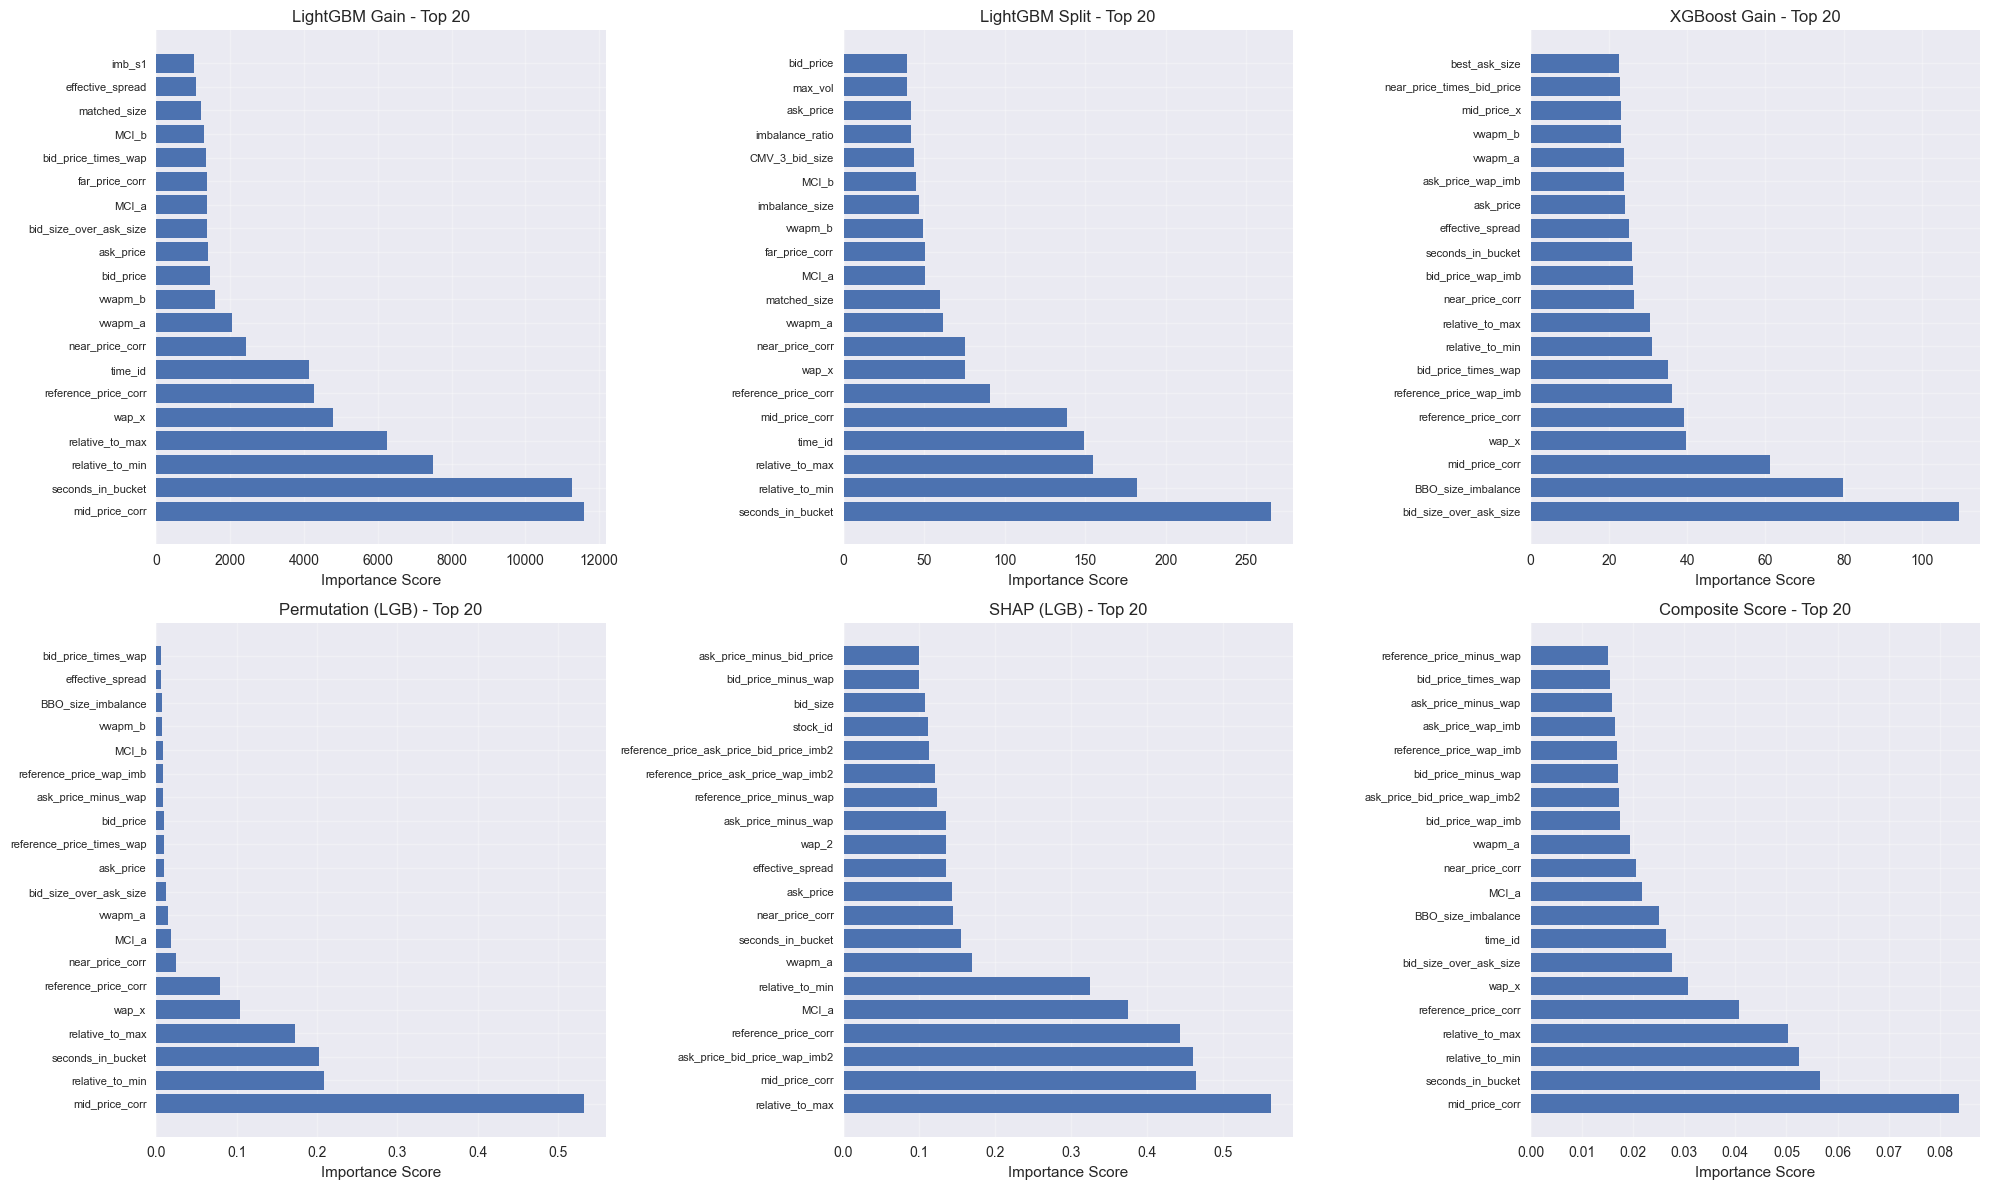

In [21]:
from matplotlib_venn import venn2, venn3
plt.style.use('seaborn-v0_8')

def plot_method_comparison(results, top_features, top_k=20):
    """比较不同方法的前N个重要特征"""
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()
    
    methods = {
        'LightGBM Gain': results['lightgbm']['gain_importance'],
        'LightGBM Split': results['lightgbm']['split_importance'],
        'XGBoost Gain': results['xgboost']['gain_importance'],
        'Permutation (LGB)': results['permutation_lgb'],
        'SHAP (LGB)': results['shap_lgb'],
        'Composite Score': top_features['composite_score']
    }
    
    for idx, (method_name, importance) in enumerate(methods.items()):
        top_features_data = importance.nlargest(top_k)
        
        axes[idx].barh(range(len(top_features_data)), top_features_data.values)
        axes[idx].set_yticks(range(len(top_features_data)))
        axes[idx].set_yticklabels(top_features_data.index, fontsize=8)
        axes[idx].set_title(f'{method_name} - Top {top_k}')
        axes[idx].set_xlabel('Importance Score')
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_method_comparison(results, top_features, top_k=20)

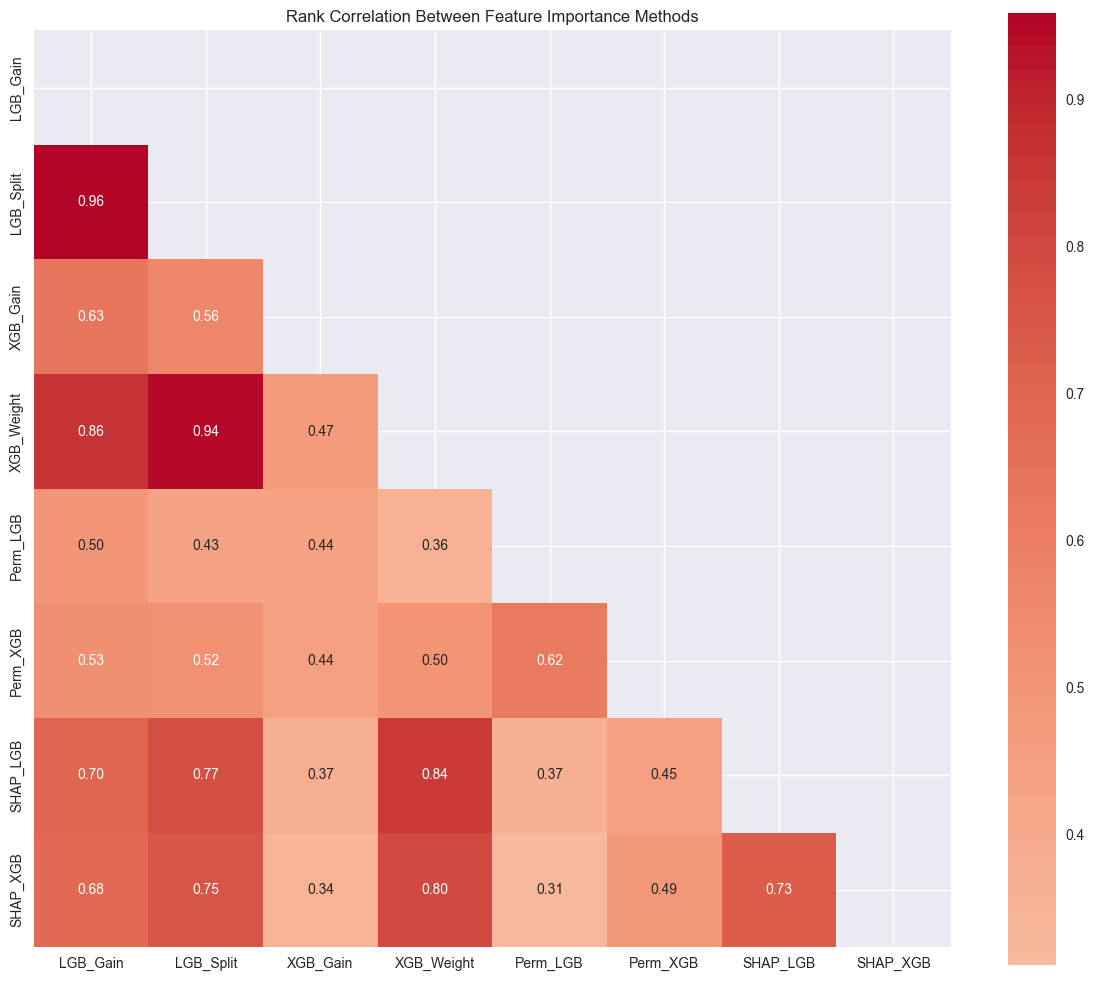

In [22]:
def plot_rank_correlation(results):
    """绘制不同方法间排名相关性热图"""
    methods_data = {
        'LGB_Gain': results['lightgbm']['gain_importance'],
        'LGB_Split': results['lightgbm']['split_importance'],
        'XGB_Gain': results['xgboost']['gain_importance'],
        'XGB_Weight': results['xgboost']['weight_importance'],
        'Perm_LGB': results['permutation_lgb'],
        'Perm_XGB': results['permutation_xgb'],
        'SHAP_LGB': results['shap_lgb'],
        'SHAP_XGB': results['shap_xgb']
    }
    
    # 计算排名相关性
    rank_df = pd.DataFrame()
    for method_name, importance in methods_data.items():
        rank_df[method_name] = importance.rank(ascending=False)
    
    correlation_matrix = rank_df.corr(method='spearman')
    
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
               center=0, fmt='.2f', square=True)
    plt.title('Rank Correlation Between Feature Importance Methods')
    plt.tight_layout()
    plt.show()
    
    return correlation_matrix


# 排名相关性
correlation_matrix = plot_rank_correlation(results)

六种方法TOP20重要的特征集合差距较大，以LGBM为例，LGBM_gain,LGBM_permutation,LGBM_shap各自产生的TOP20特征有10个重合

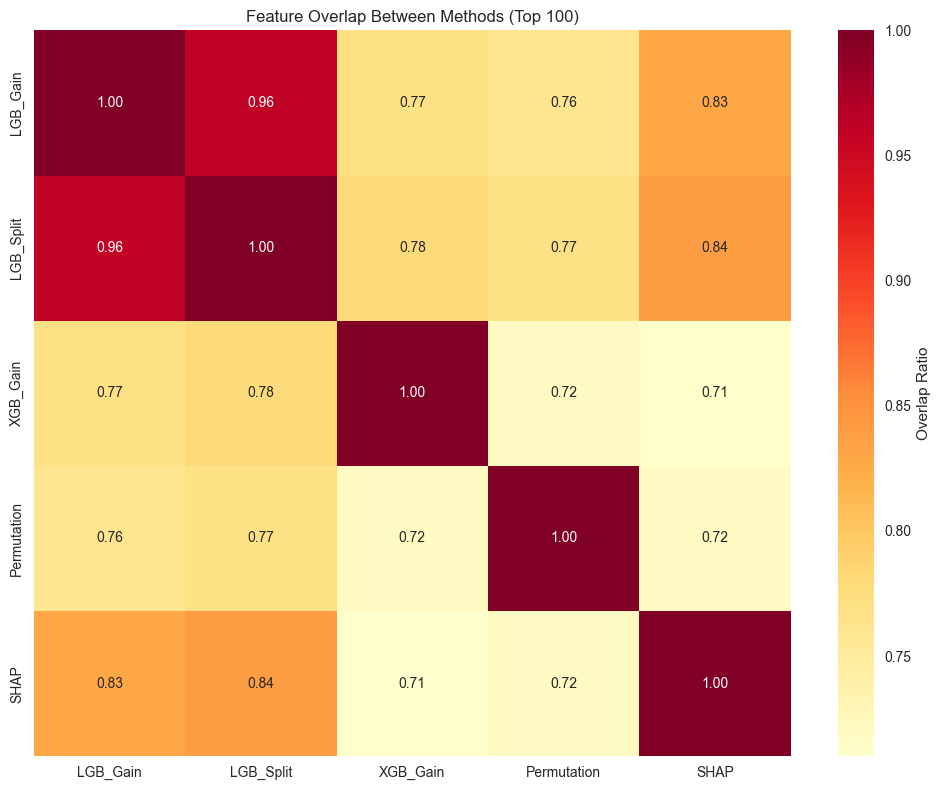

In [23]:
def plot_feature_overlap(results, top_k=50):
    """可视化不同方法间重要特征的重叠情况"""
    methods = {
        'LGB_Gain': results['lightgbm']['gain_importance'].nlargest(top_k).index,
        'LGB_Split': results['lightgbm']['split_importance'].nlargest(top_k).index,
        'XGB_Gain': results['xgboost']['gain_importance'].nlargest(top_k).index,
        'Permutation': results['permutation_lgb'].nlargest(top_k).index,
        'SHAP': results['shap_lgb'].nlargest(top_k).index
    }
    
    # 计算重叠矩阵
    overlap_matrix = pd.DataFrame(index=methods.keys(), columns=methods.keys())
    
    for method1, features1 in methods.items():
        for method2, features2 in methods.items():
            overlap = len(set(features1) & set(features2)) / top_k
            overlap_matrix.loc[method1, method2] = overlap
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(overlap_matrix.astype(float), annot=True, fmt='.2f', cmap='YlOrRd', 
               cbar_kws={'label': 'Overlap Ratio'})
    plt.title(f'Feature Overlap Between Methods (Top {top_k})')
    plt.tight_layout()
    plt.show()
    
    return overlap_matrix

def plot_venn_diagram(results, top_k=30):
    """绘制韦恩图显示核心特征的交集"""
    # 选择三种主要方法
    lgb_top = set(results['lightgbm']['gain_importance'].nlargest(top_k).index)
    perm_top = set(results['permutation_lgb'].nlargest(top_k).index)
    shap_top = set(results['shap_lgb'].nlargest(top_k).index)
    
    plt.figure(figsize=(10, 8))
    venn = venn3([lgb_top, perm_top, shap_top], 
                ('LightGBM', 'Permutation', 'SHAP'))
    
    plt.title(f'Core Feature Intersection (Top {top_k})')
    plt.show()
    
    # 返回共同特征
    common_features = lgb_top & perm_top & shap_top
    print(f"所有三种方法共同认可的特征 ({len(common_features)}个):")
    for feature in common_features:
        print(f"  - {feature}")
    
    return common_features

overlap_matrix = plot_feature_overlap(results, top_k=100)

每个方法之间的TOP100特征重合度都在70以上，用等权平均得到最终的特征也许是个合理的选择

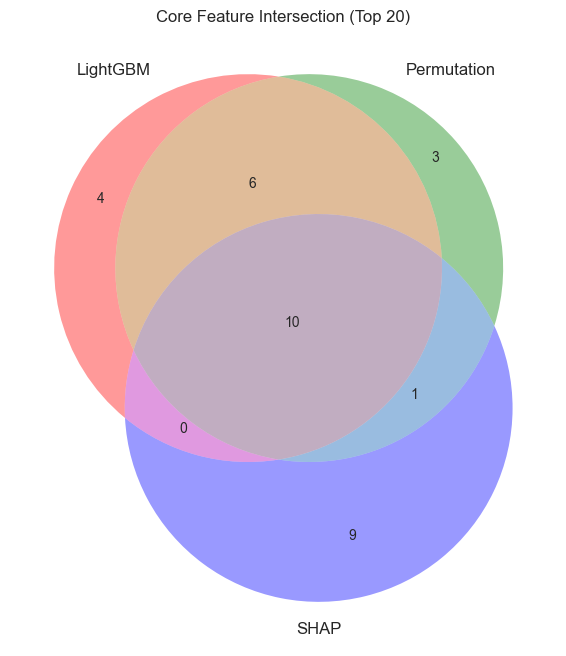

所有三种方法共同认可的特征 (10个):
  - reference_price_corr
  - effective_spread
  - near_price_corr
  - MCI_a
  - relative_to_max
  - mid_price_corr
  - ask_price
  - seconds_in_bucket
  - relative_to_min
  - vwapm_a


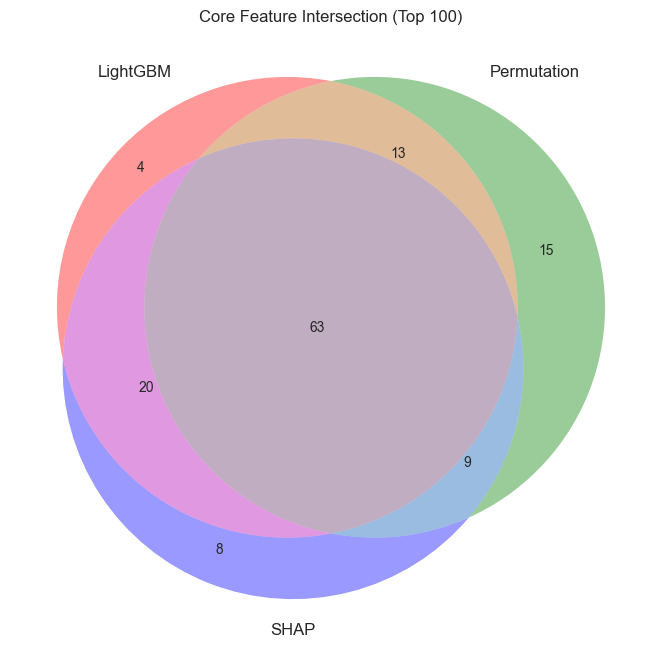

所有三种方法共同认可的特征 (63个):
  - near_price_times_ask_price
  - max_vol
  - near_price_ask_price_bid_price_imb2
  - bid_price
  - CMV_5_ask_size
  - bid_price_times_wap
  - reference_price
  - near_price_minus_ask_price
  - CMV_5_market_depth_vol
  - ask_price_minus_wap
  - reference_price_minus_wap
  - far_price_ask_price_bid_price_imb2
  - reference_price_corr
  - near_price_corr
  - reference_price_near_price_bid_price_imb2
  - reference_price_far_price_ask_price_imb2
  - imbalance_buy_sell_flag
  - far_price
  - ask_price_bid_price_wap_imb2
  - CMV_3_best_bid_size
  - reference_price_ask_price_bid_price_imb2
  - vwapm_b
  - Liquidity_2
  - MCI_b
  - far_price_near_price_ask_price_imb2
  - reference_price_times_bid_price
  - reference_price_near_price_ask_price_imb2
  - bid_price_minus_wap
  - ask_price_times_wap
  - vwapm_a
  - vwap_b
  - relative_to_max
  - effective_spread
  - wap_x
  - reference_price_far_price_near_price_imb2
  - far_price_near_price_wap_imb2
  - ask_size
  - reference

In [24]:
common_features = plot_venn_diagram(results, top_k=20)
common_features = plot_venn_diagram(results, top_k=100)

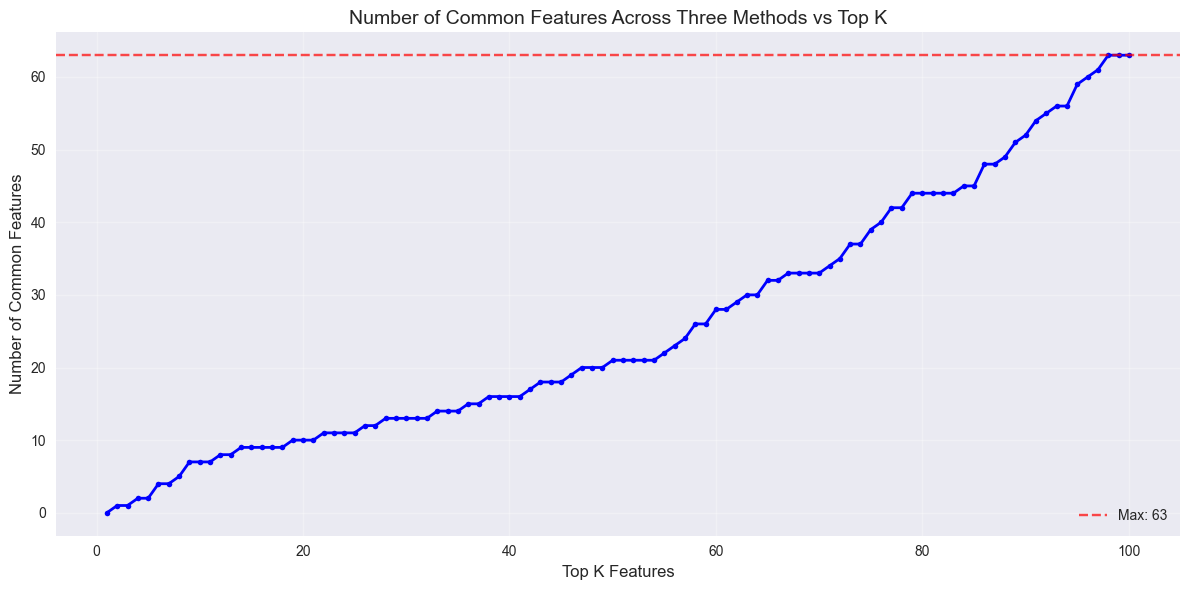

最大共同特征数量: 63 (在top_k=98时)


In [25]:
###  随着top_k从1到max_top_k变化时，三种方法共同重合特征数量
def plot_common_features_trend(results, max_top_k=100):
    # 存储不同top_k下的共同特征数量
    common_counts = []
    
    # 遍历从1到max_top_k的所有值
    for top_k in range(1, max_top_k + 1):
        # 获取每种方法的前top_k特征
        lgb_top = set(results['lightgbm']['gain_importance'].nlargest(top_k).index)
        perm_top = set(results['permutation_lgb'].nlargest(top_k).index)
        shap_top = set(results['shap_lgb'].nlargest(top_k).index)
        
        # 计算三者共同的特征数量
        common = lgb_top & perm_top & shap_top
        common_counts.append(len(common))
    
    # 绘制折线图
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, max_top_k + 1), common_counts, 
             marker='o', markersize=4, linewidth=2, color='b')
    
    # 添加标题和标签
    plt.title('Number of Common Features Across Three Methods vs Top K', fontsize=14)
    plt.xlabel('Top K Features', fontsize=12)
    plt.ylabel('Number of Common Features', fontsize=12)
    
    # 添加网格线
    plt.grid(True, alpha=0.3)
    
    # 添加参考线
    plt.axhline(y=max(common_counts), color='r', linestyle='--', alpha=0.7, 
                label=f'Max: {max(common_counts)}')
    plt.legend()
    
    # 优化布局
    plt.tight_layout()
    plt.show()
    
    # 返回结果数据
    return {
        'top_k_values': range(1, max_top_k + 1),
        'common_counts': common_counts,
        'max_count': max(common_counts),
        'max_k': np.argmax(common_counts) + 1  # +1因为索引从0开始
    }

# 使用示例
trend_results = plot_common_features_trend(results, max_top_k=100)
print(f"最大共同特征数量: {trend_results['max_count']} (在top_k={trend_results['max_k']}时)")

前 78 个特征贡献了80%的总重要性


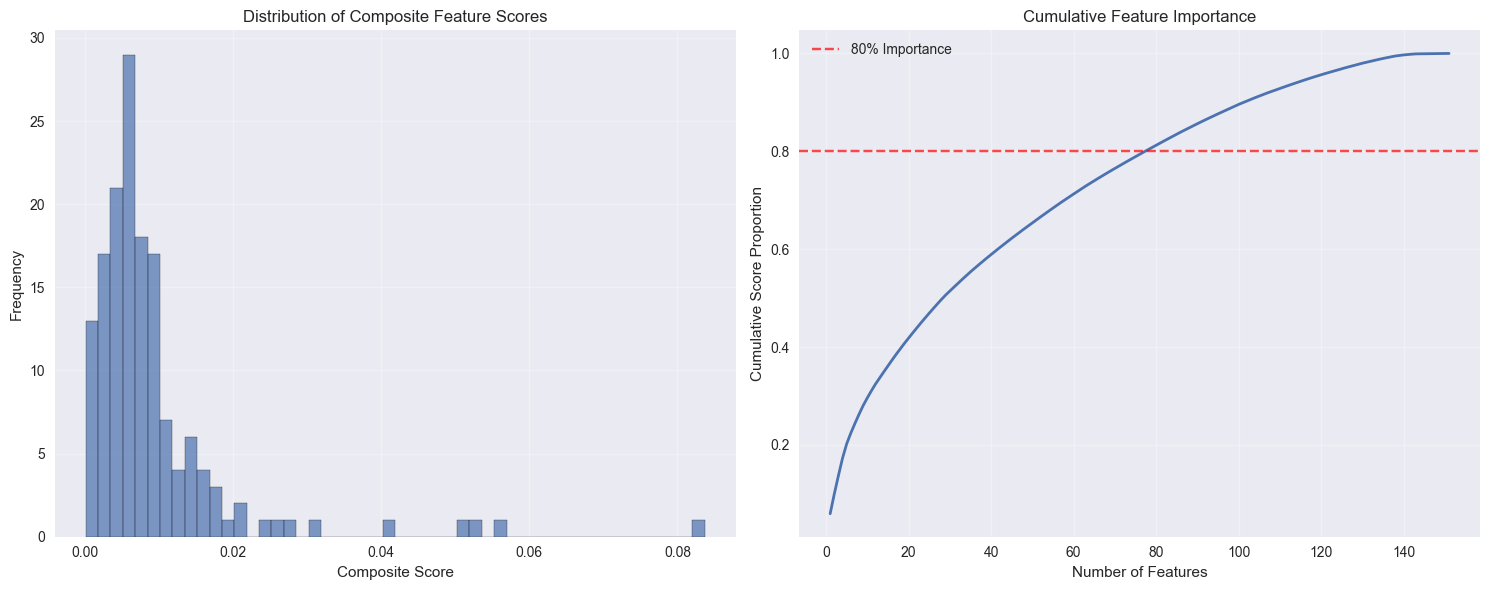

In [26]:
##### 利用加权平均方法综合得分的排名
def plot_composite_score_distribution(top_features):
    """绘制综合得分的分布"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 综合得分分布
    ax1.hist(top_features['composite_score'], bins=50, alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Composite Score')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Composite Feature Scores')
    ax1.grid(True, alpha=0.3)
    
    # 累积分布
    sorted_scores = np.sort(top_features['composite_score'])[::-1]
    cumulative = np.cumsum(sorted_scores) / np.sum(sorted_scores)
    
    ax2.plot(range(1, len(sorted_scores) + 1), cumulative, linewidth=2)
    ax2.set_xlabel('Number of Features')
    ax2.set_ylabel('Cumulative Score Proportion')
    ax2.set_title('Cumulative Feature Importance')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0.8, color='r', linestyle='--', alpha=0.7, label='80% Importance')
    ax2.legend()
    
    # 找到达到80%重要性的特征数量
    idx_80 = np.where(cumulative >= 0.8)[0][0] + 1
    print(f"前 {idx_80} 个特征贡献了80%的总重要性")
    
    plt.tight_layout()
    plt.show()
    
    return idx_80

idx_80 = plot_composite_score_distribution(top_features)

把相关性大于0.7的因子对中排名靠后的因子删掉

原始特征数量: 151
删除的高相关特征数量: 93
筛选后特征数量: 58

前10对高相关特征:
                            feature1                          feature2  \
125                  imbalance_ratio                            imb_s2   
415                        last_5min                        first_5min   
177                            wap_2                  market_depth_vol   
394              far_price_times_wap   reference_price_times_far_price   
346        far_price_times_bid_price               far_price_times_wap   
395              far_price_times_wap         far_price_times_ask_price   
23                BBO_size_imbalance                            imb_s1   
402  reference_price_times_far_price         far_price_times_ask_price   
347        far_price_times_bid_price   reference_price_times_far_price   
237             near_price_times_wap  reference_price_times_near_price   

     correlation                           removed  
125          1.0                            imb_s2  
415          1.0            

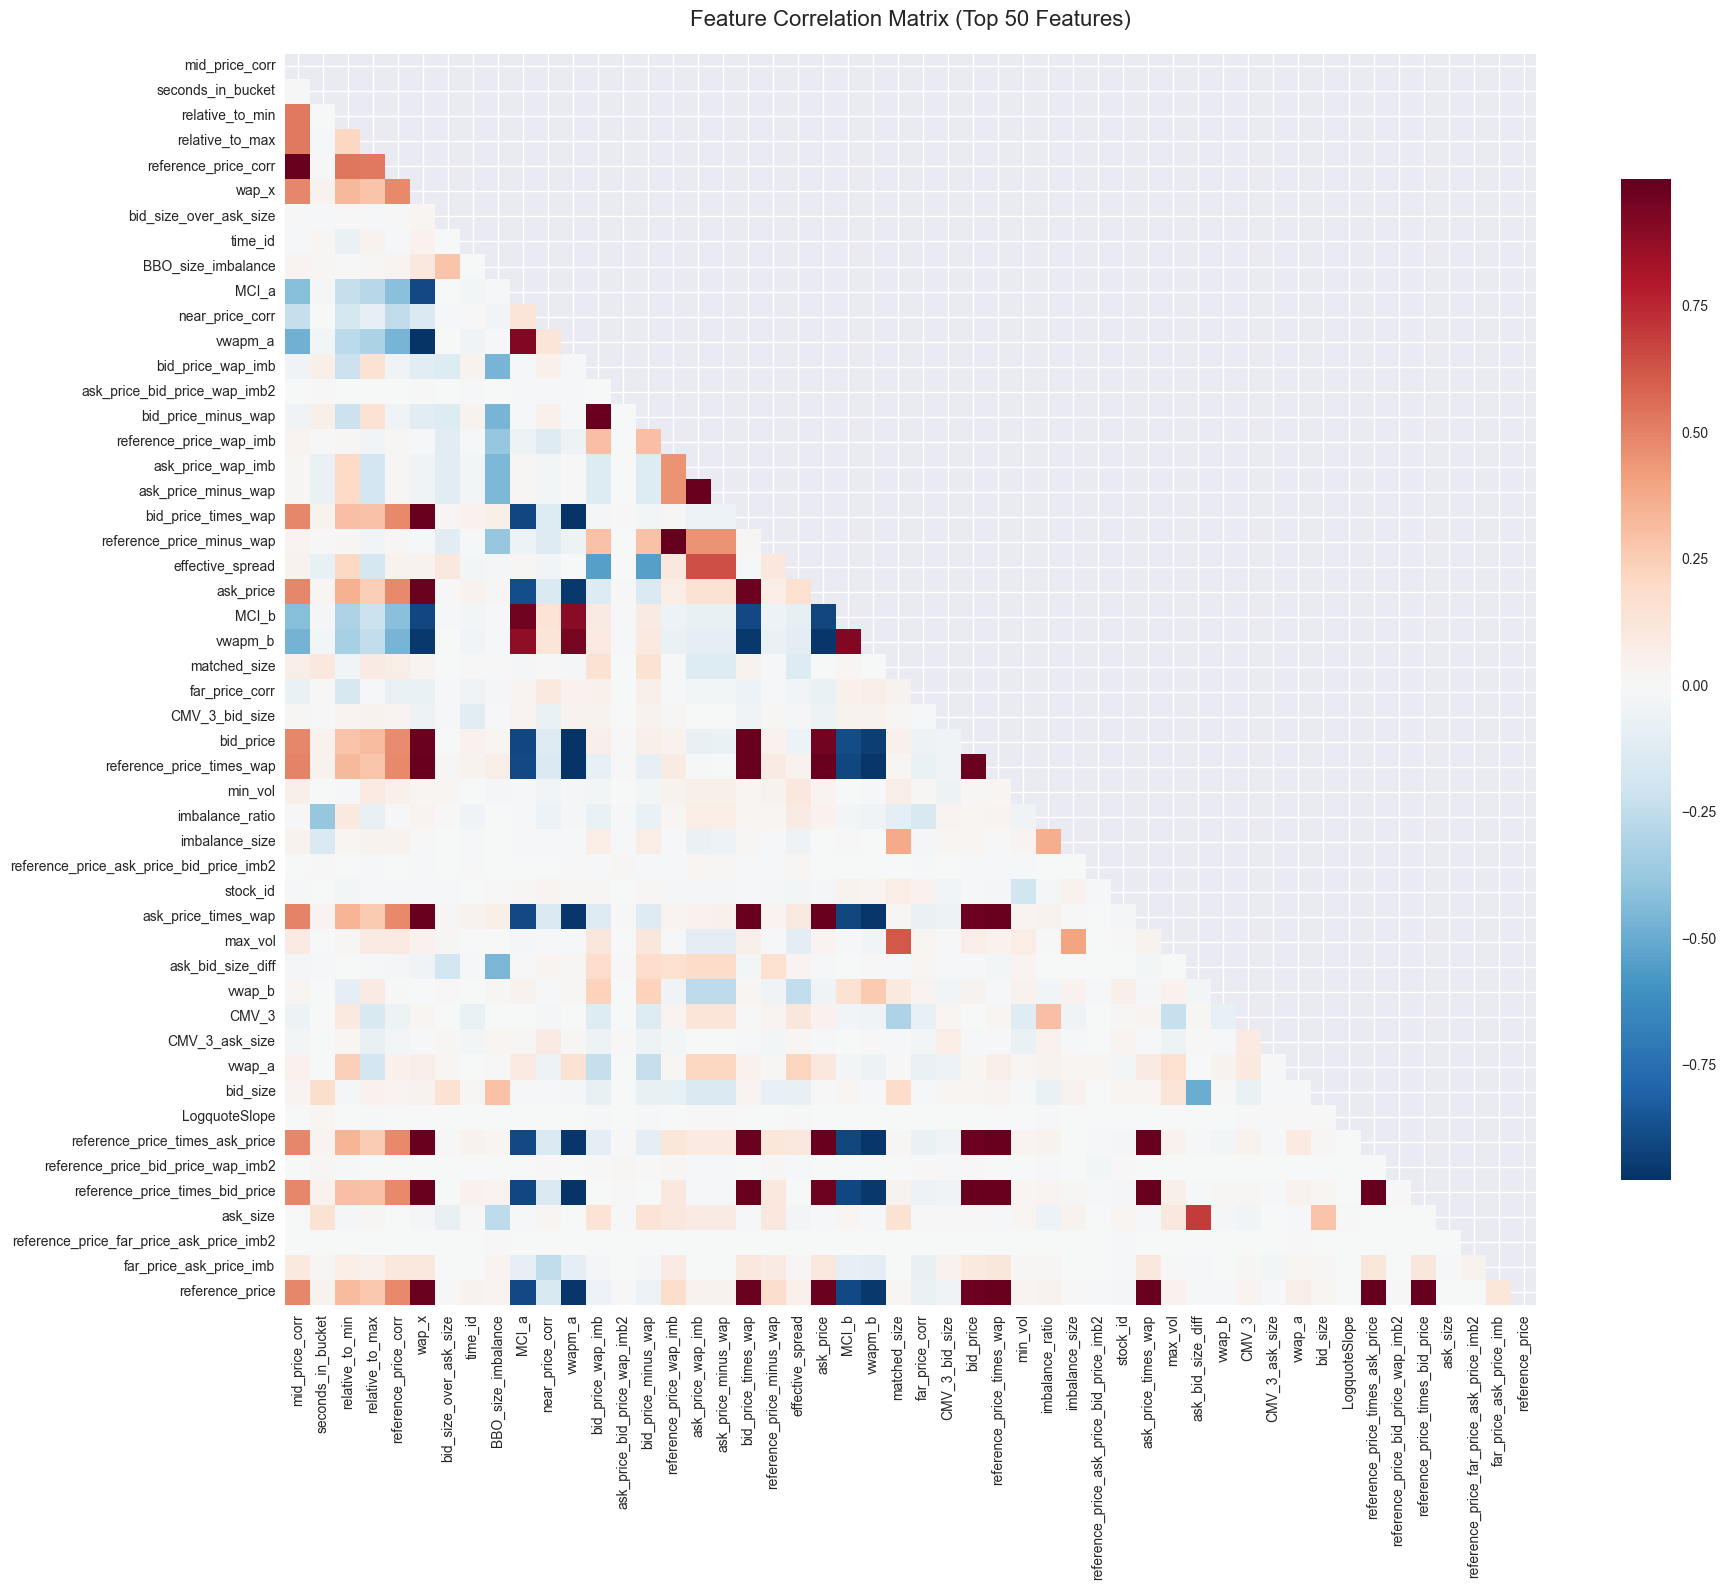

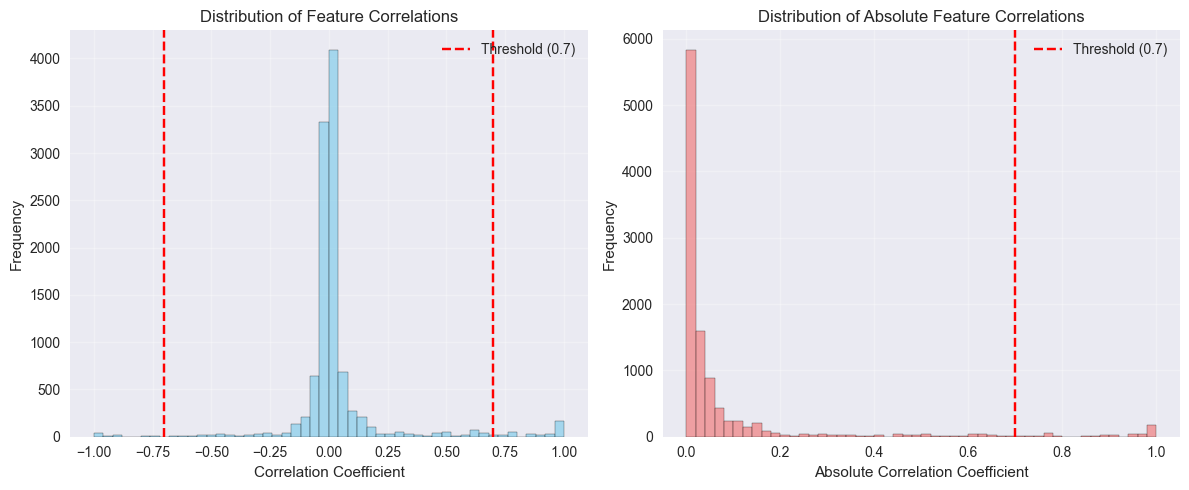

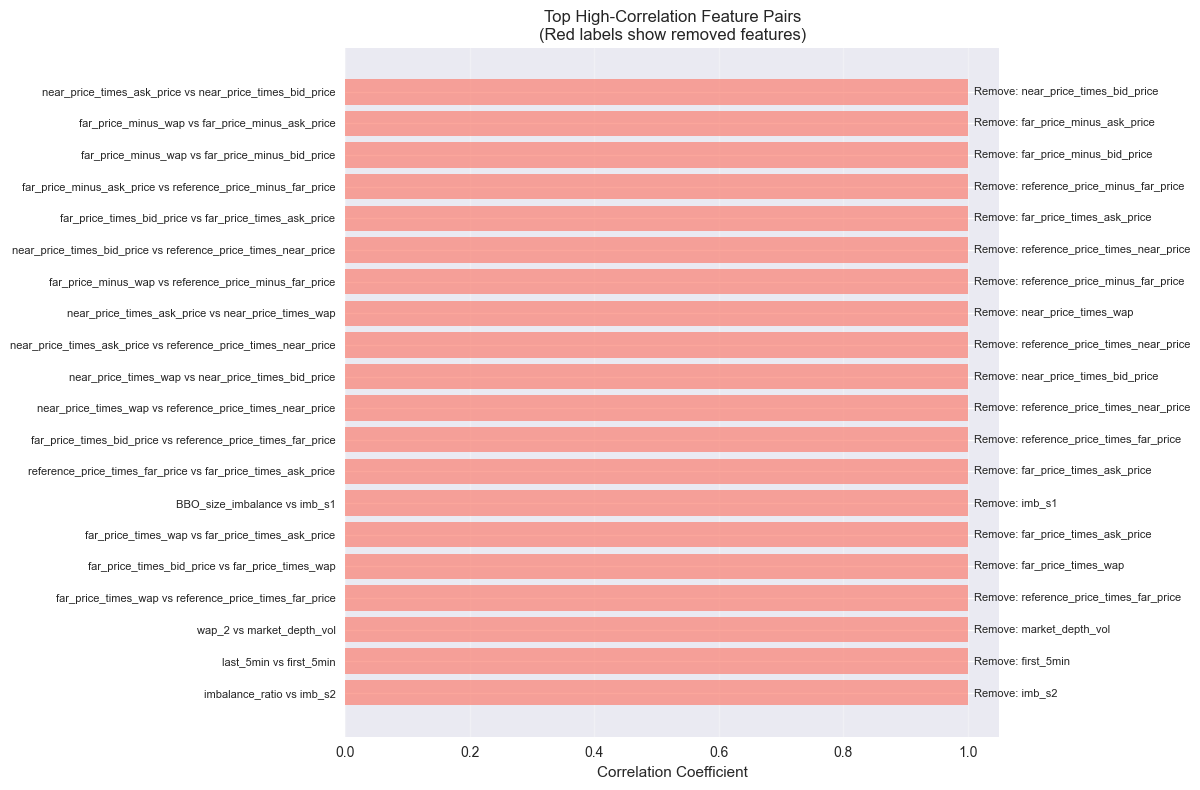

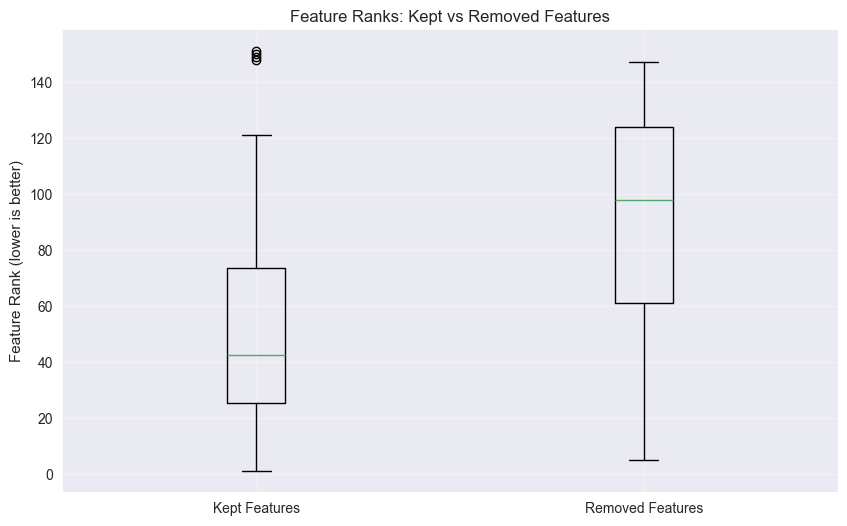

保留特征的平均排名: 52.1
删除特征的平均排名: 90.9


In [27]:
def analyze_feature_correlation(top_features, X_train, correlation_threshold=0.7):
    
    feature_names = top_features.index.tolist()
    X_top = X_train[feature_names]
    correlation_matrix = X_top.corr()
    
    # 创建特征排名字典（排名越靠前，数字越小）
    feature_ranks = {feature: i for i, feature in enumerate(feature_names)}
    
    # 找出高相关特征对
    high_corr_pairs = []
    features_to_remove = set()
    
    # 遍历上三角矩阵
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = abs(correlation_matrix.iloc[i, j])
            if corr_value > correlation_threshold:
                feature_i = correlation_matrix.columns[i]
                feature_j = correlation_matrix.columns[j]
                
                # 保留排名靠前的特征，删除排名靠后的
                if feature_ranks[feature_i] < feature_ranks[feature_j]:
                    features_to_remove.add(feature_j)
                else:
                    features_to_remove.add(feature_i)
                
                high_corr_pairs.append({
                    'feature1': feature_i,
                    'feature2': feature_j,
                    'correlation': corr_value,
                    'rank1': feature_ranks[feature_i],
                    'rank2': feature_ranks[feature_j],
                    'removed': feature_j if feature_ranks[feature_i] < feature_ranks[feature_j] else feature_i
                })
    
    # 筛选后的特征
    selected_features = [f for f in feature_names if f not in features_to_remove]
    
    print(f"原始特征数量: {len(feature_names)}")
    print(f"删除的高相关特征数量: {len(features_to_remove)}")
    print(f"筛选后特征数量: {len(selected_features)}")
    
    # 显示高相关特征对
    if high_corr_pairs:
        high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False)
        print("\n前10对高相关特征:")
        print(high_corr_df.head(10)[['feature1', 'feature2', 'correlation', 'removed']])
    
    return selected_features, correlation_matrix, high_corr_df

def plot_correlation_analysis(correlation_matrix, selected_features, top_features, high_corr_df):
    """
    绘制相关性分析相关的可视化
    """

    plt.figure(figsize=(20, 16))
    
    # 选择前50个特征绘制热图
    top_50_features = top_features.head(50).index
    corr_top_50 = correlation_matrix.loc[top_50_features, top_50_features]
    
    mask = np.triu(np.ones_like(corr_top_50, dtype=bool))
    sns.heatmap(corr_top_50, mask=mask, cmap='RdBu_r', center=0, 
                square=True, annot=False, cbar_kws={"shrink": .8})
    plt.title('Feature Correlation Matrix (Top 50 Features)', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    # 2. 相关性分布直方图
    plt.figure(figsize=(12, 5))
    
    # 提取上三角矩阵的值（不包括对角线）
    corr_values = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)]
    corr_values_abs = np.abs(corr_values)
    
    plt.subplot(1, 2, 1)
    plt.hist(corr_values, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
    plt.axvline(x=0.7, color='red', linestyle='--', label=f'Threshold (0.7)')
    plt.axvline(x=-0.7, color='red', linestyle='--')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Frequency')
    plt.title('Distribution of Feature Correlations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist(corr_values_abs, bins=50, alpha=0.7, edgecolor='black', color='lightcoral')
    plt.axvline(x=0.7, color='red', linestyle='--', label=f'Threshold (0.7)')
    plt.xlabel('Absolute Correlation Coefficient')
    plt.ylabel('Frequency')
    plt.title('Distribution of Absolute Feature Correlations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 3. 高相关特征对的可视化
    if not high_corr_df.empty:
        plt.figure(figsize=(12, 8))
        top_high_corr = high_corr_df.head(20).copy()
        
        # 创建条形图
        y_pos = np.arange(len(top_high_corr))
        plt.barh(y_pos, top_high_corr['correlation'], color='salmon', alpha=0.7)
        
        # 标注被删除的特征
        for i, (idx, row) in enumerate(top_high_corr.iterrows()):
            plt.text(row['correlation'] + 0.01, i, 
                    f"Remove: {row['removed']}", 
                    va='center', fontsize=8)
        
        plt.yticks(y_pos, [f"{row['feature1']} vs {row['feature2']}" 
                          for _, row in top_high_corr.iterrows()], fontsize=8)
        plt.xlabel('Correlation Coefficient')
        plt.title('Top High-Correlation Feature Pairs\n(Red labels show removed features)')
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
    
    # 4. 特征选择前后对比
    original_features = correlation_matrix.columns.tolist()
    removed_features = set(original_features) - set(selected_features)
    
    # 计算删除特征的平均排名
    if removed_features:
        removed_ranks = [top_features.index.get_loc(f) + 1 for f in removed_features]
        kept_ranks = [top_features.index.get_loc(f) + 1 for f in selected_features]
        
        plt.figure(figsize=(10, 6))
        plt.boxplot([kept_ranks, removed_ranks], 
                   labels=['Kept Features', 'Removed Features'])
        plt.ylabel('Feature Rank (lower is better)')
        plt.title('Feature Ranks: Kept vs Removed Features')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        print(f"保留特征的平均排名: {np.mean(kept_ranks):.1f}")
        print(f"删除特征的平均排名: {np.mean(removed_ranks):.1f}")


selected_features, correlation_matrix, high_corr_df = analyze_feature_correlation(
        top_features, X_train, correlation_threshold = 0.7
    )
plot_correlation_analysis(correlation_matrix, selected_features, top_features, high_corr_df)

# 5.减少multilinear影响的方法

**顺序有一些变化**

1. permutation, 换seed
2. SHAP值

gain、split、count和萨巴斯法得出的特征重要性值都是不一致的。这意味着模型可能会发生变化，从而更加依赖于某个给定的特征，但分配给该特征的重要性估计值却会降低。 在我们考虑的方法中，只有 SHAP 值和基于排列的方法是一致的。  
“the feature importance values from the gain,split, count, and Saabas methods are all inconsistent. This means that a model can change such that it relies more on a given feature, yet the importance estimate assigned to that feature decreases.  Of the methods weconsider,only SHAP values and permutation based methods arec onsistent.”

![attribution.png](attribution.png)

In [ ]:
# result1 = []#cross_section_features[['reference_price',"matched_size"]].copy()
# def section_scalar(df):
#     # 对 'reference_price' 列进行标准化
#     scaler = StandardScaler()
#     scaler.fit(df)
#     print(df.info())
#     scaled_values = scaler.fit_transform(df)
#     result1.extend(scaled_values.tolist())
#     del scaled_values
#     gc.collect()
#     return 

# tqdm.pandas(desc="Processing groups")
# # 对每个分组应用标准化
# scaled_f1 = (
#     cross_section_features
#     [selected_cols]
#     #.query("date_id<10")
#     #.dropna(axis=1)
#     .drop(["stock_id","row_id","time_id","imbalance_buy_sell_flag",'seconds_in_bucket'],axis=1)
#     .groupby(['date_id'])
#     .progress_apply(section_scalar)
# )

In [ ]:
# scaled_cross_section_features = pd.DataFrame(np.array(result1),
#              index=cross_section_features.sort_values("date_id").row_id,
#              columns=cross_section_features[selected_cols].drop(["stock_id","row_id","time_id","imbalance_buy_sell_flag",'seconds_in_bucket'],axis=1).columns
#             )

In [ ]:
# # 计算 VIF
# def calculate_vif(df):
#     vif_data = pd.DataFrame()
#     vif_data["Variable"] = df.columns
#     vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in tqdm(range(df.shape[1]))]
#     return vif_data

# # 假设 df 只有数值型数据
# vif_result = calculate_vif(X_train.replace(np.nan,0))#cross_section_features[selected_cols].drop(["stock_id","row_id","time_id","imbalance_buy_sell_flag",'seconds_in_bucket','date_id'],axis=1).replace(np.nan,0).iloc[:,:])